# TRUST4 Exercise

This notebook contains the implementation and descriptions of the TRUST4 excercise from Numenos.

## Introduction
The notebook contains the following main sections:
1. `Configurations` - installs and generates reference data, and installs the TRUST4 docker image. Run this section only once.
2. `Pipeline` - runs TRUST4 on a given BAM/fastaq file and analyzes the results. The section can be executed multiple times on different BAM/fastaq files.

## Flow
1. Run the sections `Functions` and `Configurations` once
2. Run the section `'Pipeline` on a given BAM/fastaq file

## Improvements
- The pipeline is implemented here in a Jupyter notebook due to convenience considerations since it is an evaluation exercise. In general, the pipeline should be implemented in python scipts to accomodate efficient workflows and executions (e.g., job scheduling)
- The functions (in the `Functions` section) should be implemented in a `./Utils/util.py` file, and imported here.
- Consider workflow management framework

## References:
- [TRUST4 git hub](https://github.com/liulab-dfci/TRUST4)
- [SRA toolkit](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit)
- [GEO](https://www.ncbi.nlm.nih.gov/geo/)

## Challenges Encountered 
- Downloading samples from [GEO](https://www.google.com/search?client=safari&rls=en&q=GEO&ie=UTF-8&oe=UTF-8) requires (in most cases) an AWS or a Google bucket, or using the [SRA toolkit](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit). Using the SRA toolkit, one needs to know if the sample is aligned (to generate a BAM file) or un-aligned (to generate the fastaq files(s)). This information may be present in the sample page. Otherwise, use the `sra-stat --xml ./SRR28479474 > info.xml` command from the SRA toolkit and look in the `<AlignInfo>` field.

## Notes
- The implementation below uses the `TRUST4 docker` image to run TRUST4. Thus, make sure `docker` is installed.

## QC Considerations
- Benchmarking TRUST4's results against other established reconstruction tools. Consistency between tools in identifying clonotypes and diversity metrics can validate the reliability of the results
- Comparing the diversity of the V, J, D, and C genes reported with known gene usage patterns 


In [1]:
from pathlib import Path
import os

import pandas as pd

## Functions

In [ ]:
import subprocess

type CommandOut = tuple[bool, str, str]

def run_command(command: str) -> CommandOut:
    """Execute bash shell command.

    Args:
        command (str): shell command.

    Returns:
        tuple[bool, str, str]: exit_ok, stdout, stderr.
    """
    ret = subprocess.run(command, shell=True, capture_output=True, check=False)
    return ret.returncode==0, ret.stdout.decode(), ret.stderr.decode()

class TRUSTContainer():
    """TRUST4 docker container."""
    def __init__(self, data_folder: str, ref_folder: str, output_folder: str, image: str, *, platform: str = 'linux/amd64') -> None:
        self.image = image
        self.bind_info: dict[str, str] = {'/ref': ref_folder, '/data': data_folder, '/out': output_folder}
        self.base_command: str = f"docker run --platform {platform} " + ' '.join(f"-v {v}:{k}" for k, v in self.bind_info.items()) + f" {self.image} run-trust4"

    def usage(self) -> CommandOut:
        """Shows usage"""
        return run_command(self.base_command)

    def _generate_command(self, ref_file: str, coordinate_file: str, extra_params: str | None = None) -> str:
        """command with --ref and -f options."""
        command = self.base_command + f" --ref /ref/{ref_file} -f /ref/{coordinate_file} --od /out"
        if extra_params is not None:
            command += f" {extra_params}"
        return command

    def generate_BAM_command(self, ref_file: str, coordinate_file: str, bam_file: str, extra_params: str | None = None) -> str:
        """generates the command to analyse a BAM file"""
        return self._generate_command(ref_file, coordinate_file, extra_params=extra_params) + f" -b /data/{bam_file}"
    
    def generate_paired_fastaq_command(self, ref_file: str, coordinate_file: str, fasta_file1: str, fasta_file2: str, extra_params: str | None = None) -> str:
        """generates a command to analyze fastaq files/"""
        return self._generate_command(ref_file, coordinate_file, extra_params=extra_params) + f" -1 /data/{fasta_file1} -2 /data/{fasta_file2}"
    
    def generate_single_fastaq_command(self, ref_file: str, coordinate_file: str, fasta_file: str, extra_params: str | None = None) -> str:
        """generates a command to analyze fastaq files/"""
        return self._generate_command(ref_file, coordinate_file, extra_params=extra_params) + f" -u /data/{fasta_file}"

    def run_BAM(self, ref_file: str, coordinate_file: str, bam_file: str, extra_params: str | None = None) -> CommandOut:
        """runs TRUST4 on BAM input file."""
        return run_command(
            self.generate_BAM_command(ref_file, coordinate_file, bam_file, extra_params=extra_params)
        )

    def run_paired_fastaq(self, ref_file: str, coordinate_file: str, fasta_file1: str, fasta_file2: str, extra_params: str | None = None) -> CommandOut:
        """runs TRUST4 on paired fastaq files."""
        return run_command(
            self.generate_paired_fastaq_command(ref_file, coordinate_file, fasta_file1, fasta_file2, extra_params=extra_params)
        )
    
    def run_single_fastaq(self, ref_file: str, coordinate_file: str, fasta_file: str, extra_params: str | None = None) -> CommandOut:
        """Runs TRUST4 on single fastaq file."""
        return run_command(
            self.generate_single_fastaq_command(ref_file, coordinate_file, fasta_file, extra_params=extra_params)
        )


## Configurations
Run this section once to load and generate configurations files and the TRUST docker image.

### Parameters

In [3]:
# Parameters
# ==========

# folder to hold reference files
reference_path: Path = Path('./Reference')  # will hold all reference files

# reference files
genecode_file: Path = reference_path / 'genecode_annotation.gtf'  # annotation file
hg38_ref_file: Path = reference_path / 'Homo_sapients_GRCh38.fa'  # hg38 reference genome fasta file
VDJC_gene_ref_file: Path = reference_path / 'IMGT+C.fa'  # for the --ref file

# BCR and TCR sequences and names
bcr_tcr_gene_name_file: Path = reference_path / 'bcr_tcr_gene_name.txt'  # BCR and TCR gene names (required for generating the -f file)
bcr_tcr_gene_seq_file: Path = reference_path / 'bcrtcr.fa'  # for the -f option (when using BAM files)

# TRUST4 docker
data_path: str = os.path.abspath('./Data')  # BAM files folders
ref_path: str = os.path.abspath(reference_path)  # reference files folder
out_path: str = os.path.abspath('./Output')  # TRUST output files folder
docker_container: str = 'quay.io/biocontainers/trust4:1.1.5--h5ca1c30_0'


### Configure

In [ ]:
# download genecode annotation file
command = f"wget -qO- https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_47/gencode.v47.annotation.gtf.gz | gunzip > {genecode_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# download Ensembl GRCh38 genome
command = f"wget -qO- https://ftp.ensembl.org/pub/release-113/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz | gunzip > {hg38_ref_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# create the --ref file
command = f"perl BuildImgtAnnot.pl Homo_sapien > {VDJC_gene_ref_file}"
ret, stdout, stderr = run_command(command)
print(ret)


In [ ]:
# generate BCR and TCR gene names (needed for generating the -f file)
command = f"""grep ">" {VDJC_gene_ref_file} | cut -f2 -d'>' | cut -f1 -d'*' | sort | uniq > {bcr_tcr_gene_name_file}"""
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# creare the BCR and TCR sequences (for the -f option)
command = f"perl BuildDatabaseFa.pl {hg38_ref_file} {genecode_file} {bcr_tcr_gene_name_file} > {bcr_tcr_gene_seq_file}"
ret, stdout, stderr = run_command(command)
print(ret)

In [ ]:
# Get the TRUST4 docker image. Make sure docker is installed.
command = f"docker pull {docker_container}"
ret, stdout, stderr = run_command(command)
print(ret)

# verify
!docker image ls | grep {docker_container.split(':')[0]}

## Verify (Optional)
We run `TRUST4` on the provided example BAM file to make sure TRUST4 is running properly.

In [4]:
# first show usage
example_data_path: str = os.path.abspath('./example')
example_ref_path: str = os.path.abspath('./')
example_out_path: str = os.path.abspath('./example/Output')
# -----------------------------------
trust4c_exp = TRUSTContainer(example_data_path, example_ref_path, example_out_path, docker_container)
ret, stdout, stderr = trust4c_exp.usage()
print(ret, stdout, stderr, sep='\n')

False

TRUST4 v1.1.5-r573 usage: ./run-trust4 [OPTIONS]:
Required:
	-b STRING: path to bam file
	-1 STRING -2 STRING: path to paired-end read files
	-u STRING: path to single-end read file
	-f STRING: path to the fasta file coordinate and sequence of V/D/J/C genes
Optional:
	--ref STRING: path to detailed V/D/J/C gene reference file from IMGT database. (default: not used but recommended)
	-o STRING: prefix of output files. (default: inferred from file prefix)
	--od STRING: the directory for output files. (default: ./)
	-t INT: number of threads (default: 1)
	-k INT: the starting k-mer size for indexing contigs (default: 9)
	--barcode STRING: if -b, bam field for barcode; if -1 -2/-u, file containing barcodes (default: not used)
	--barcodeLevel STRING: barcode is for cell or molecule (default: cell)
	--barcodeWhitelist STRING: path to the barcode whitelist (default: not used)
	--barcodeTranslate STRING: path to the barcode translate file (default: not used)
	--UMI STRING: if -b, bam fie

In [5]:
# now run on example BAM file (with provided reference files)
bam_file: Path = Path('example.bam')
# -----------------------------------
ret, stdout, stderr = trust4c_exp.run_BAM('human_IMGT+C.fa', 'hg38_bcrtcr.fa', bam_file.name)
print(ret, stdout, stderr, sep='\n')


True

[Tue Apr  1 07:35:39 2025] TRUST4 v1.1.5-r573 begins.
[Tue Apr  1 07:35:39 2025] SYSTEM CALL: /usr/local/bin/bam-extractor -b /data/example.bam -t 1 -f /ref/hg38_bcrtcr.fa -o /out/TRUST_example_toassemble 
[Tue Apr  1 07:35:39 2025] Start to extract candidate reads from bam file.
[Tue Apr  1 07:35:39 2025] Finish obtaining the candidate read ids.
[Tue Apr  1 07:35:39 2025] Finish extracting reads.
[Tue Apr  1 07:35:39 2025] SYSTEM CALL: /usr/local/bin/trust4  -f /ref/hg38_bcrtcr.fa -o /out/TRUST_example -1 /out/TRUST_example_toassemble_1.fq -2 /out/TRUST_example_toassemble_2.fq
[Tue Apr  1 07:35:40 2025] Start to assemble reads.
[Tue Apr  1 07:35:40 2025] Found 394 reads.
[Tue Apr  1 07:35:40 2025] Finish sorting the reads.
[Tue Apr  1 07:35:40 2025] Finish rough annotations.
[Tue Apr  1 07:35:40 2025] Assembled 394 reads.
[Tue Apr  1 07:35:40 2025] Try to rescue 0 reads for assembly.
[Tue Apr  1 07:35:40 2025] Rescued 0 reads.
[Tue Apr  1 07:35:40 2025] Extend assemblies by mate

In [6]:
# verify
!bash mytrust_example_test.sh

TRUST4 is ready to use.


In [ ]:
# now use the paired fastaq files
ret, stdout, stderr = trust4c_exp.run_paired_fastaq('human_IMGT+C.fa', 'hg38_bcrtcr.fa', 'example_1.fq', 'example_2.fq')
print(ret, stdout, stderr, sep='\n')

In [ ]:
# verify
!bash mytrust_example_test.sh

In [ ]:
# show generated report
report_file: Path = Path(example_out_path) / f'TRUST_{bam_file.stem}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
display(df)

In [ ]:
# now run with generated reference files
trust4c = TRUSTContainer(data_path, ref_path, out_path, docker_container)
ret, stdout, stderr = trust4c.run_BAM(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, bam_file.name)
print(ret, stdout, stderr, sep='\n')

In [ ]:
# show example generated report
report_file: Path = Path(out_path) / f'TRUST_{bam_file.stem}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
display(df)

# Analysis Pipeline

In this section we run the pipeline on samples.

### Data
In the example below, we use several samples from this GEO [Dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE262648): The tumor immune microenvironment and therapeutic efficacy of trastuzumab deruxtecan in gastric cancer.

### Pre-requisite
We are using the SRA toolkit to download the GEO samples:
- download the [SRA toolkit](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit)
- once download, execute `tar -xzvf sratoolkit.3.2.1-mac-arm64.tar`

The SRA toolkit resides in `./Tools/sratoolkit.3.2.1/bin` folder.

**Samples choosen**:
- SRX24082037: GSM8172959: Sbj3_BL; Homo sapiens; RNA-Seq. Run accession number is SRR28479475
- SRX24082038: GSM8172960: Sbj4_BL; Homo sapiens; RNA-Seq. Run accession number is SRR28479474

**Downloading a sample**:
1. Go to the GEO [Dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE262648)
1. Click on a sample from the Samples row (e.g., GSM8172959)
1. Click on the SRA accession number at the bottom (under `Relations`), This will open the corresponding SRA page. Copy the corresponding SRA run accession (e.g. `SRR28479474`).
1. To download the sample (e.g., `SRR28479474`), use the SRA toolkit as follows:

    1. `prefetch SRR28479474`(or `prefetch SRX24082038`) - this downloads the sample in a `.sra` format
    1. if the sample is not alligned (as in this case), perform: `fasterq-dump.3.2.1 ./SRR28479474 -t ./temp -O ./SRR28479474` - this will generate the fastaq file(s)
    1. if the sample is aligned, perform `sam-dump.3.2.1 ./SRR28479474/SRR28479474.sra > ./SRR28479474/SRR28479474.sam` and then generate the BAM file by executing `samtools view -bS ./SRR28479474/SRR28479474.sam > ./SRR28479474/SRR28479474.bam`


In [7]:
# instantiate a TRUST4 class
trust4c = TRUSTContainer(data_path, ref_path, out_path, docker_container)

In [ ]:
''' 
Run the pipeline on a single-end fastaq file.

In case of a BAM file, execute instead: 
    ret, stdout, stderr = trust4c.run_BAM(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, bam_file, extra_params=f" -t {num_threads}")

In case of paired fasta/fastq files, execute instead:
    ret, stdout, stderr = trust4c.run_paired_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastaq_file1, fastaq_file2, extra_params=f" -t {num_threads}")

Note:
- For fastaq input file(s), the coordinate_file input (second input in the run method) can be identical to the ref_file input (first input in the run method) as the coordinates are not needed in this case. Thus, e.g., running 
    trust4c.run_single_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastaq_file, extra_params=f" -t {num_threads}"), or 
    trust4c.run_single_fastaq(VDJC_gene_ref_file.name, VDJC_gene_ref_file.name, fastaq_file, extra_params=f" -t {num_threads}") 
will yield the same results.
'''
#fastaq_file: str = 'SRR28479475.fastq'
fastaq_file: str = 'SRR28479474.fastq'

num_threads: int = 8  # number of required threads
# ------------------------------------------------
ret, stdout, stderr = trust4c.run_single_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastaq_file, extra_params=f" -t {num_threads}")
print(ret, stdout, stderr, sep='\n')

True

[Tue Apr  1 08:13:50 2025] TRUST4 v1.1.5-r573 begins.
[Tue Apr  1 08:13:50 2025] SYSTEM CALL: /usr/local/bin/fastq-extractor -t 8 -f /ref/bcrtcr.fa -o /out/TRUST_SRR28479474_toassemble  -u /data/SRR28479474.fastq
[Tue Apr  1 08:13:50 2025] Start to extract candidate reads from read files.
[Tue Apr  1 08:26:25 2025] Finish extracting reads.
[Tue Apr  1 08:26:26 2025] SYSTEM CALL: /usr/local/bin/trust4  -t 8 -f /ref/bcrtcr.fa -o /out/TRUST_SRR28479474 -u /out/TRUST_SRR28479474_toassemble.fq
[Tue Apr  1 08:26:26 2025] Start to assemble reads.
[Tue Apr  1 08:26:28 2025] Found 124528 reads.
[Tue Apr  1 08:26:29 2025] Finish sorting the reads.
[Tue Apr  1 08:26:33 2025] Finish rough annotations.
[Tue Apr  1 08:26:38 2025] Processed 100000 reads (30295 are used for assembly).
[Tue Apr  1 08:26:44 2025] Assembled 38399 reads.
[Tue Apr  1 08:26:44 2025] Try to rescue 462 reads for assembly.
[Tue Apr  1 08:26:44 2025] Rescued 89 reads.
[Tue Apr  1 08:26:48 2025] SYSTEM CALL: /usr/local/bin

In [ ]:
# show generated report
report_file: Path = Path(out_path) / f'TRUST_{Path(fastaq_file).stem}_report.tsv'
df = pd.read_csv(report_file, sep='\t').rename(columns={'#count': 'count'})
print(f"Report from {report_file}:")
display(df)

Report from /Users/yoramzarai/work/Ramot/Projects/Exercises/TRUST4/Output/TRUST_SRR28479474_report.tsv:


,count,frequency,CDR3nt,CDR3aa,V,D,J,C,cid,cid_full_length
0,58,0.040357,TGCCAACAGTATAATAGTTATTCTATGTGGACGTTC,CQQYNSYSMWTF,IGKV1-5*03,.,IGKJ1*01,IGKC,assemble12,0
1,50,0.034294,TGCGGAACATGGGAAAGCAGCCTGAGTGCTGGGGTGTTC,CGTWESSLSAGVF,IGLV1-51*01,.,IGLJ3*02,IGLC,assemble75,0
2,48,0.180451,TGTGCTAGAGATGGCGCCCCACATTTTAACTGGTTACTTGACCACTGG,CARDGAPHFNWLLDHW,IGHV4-39*07,IGHD3-9*01,IGHJ4*02,.,assemble100,0
3,47,0.032846,TGTCAACAGAGTTACGGTAGTCCTCCCACTTTT,CQQSYGSPPTF,IGKV1-39*01,.,IGKJ2*01,IGKC,assemble60,0
4,42,0.029177,TGTCAACAGAGTTACAGTCCCCTTTACACTTTT,CQQSYSPLYTF,IGKV1-39*01,.,IGKJ2*01,IGKC,assemble38,0
...,...,...,...,...,...,...,...,...,...,...
335,1,0.000686,TTTCAACAGAGTTACAGTACCCCCGGGACGTTC,FQQSYSTPGTF,IGKV1-39*01,.,IGKJ1*01,IGKC,assemble4578,0
336,1,0.000686,TGTGTGGTGTATATGGGTGGTGGCATTTGGGTGTTC,CVVYMGGGIWVF,IGLV8-61*01,.,IGLJ3*02,IGLC,assemble1656,0
337,1,0.000686,TGTTCAGCATGGGATGACTACCTGCATGGTCTGTTC,CSAWDDYLHGLF,IGLV1-44*01,.,IGLJ3*02,IGLC,assemble4710,0
338,1,0.003759,TGTGCACGGATACGCGGGGATATTTTGACTGGTTATTATAACTTTG...,CARIRGDILTGYYNFDAFDIW,IGHV2-70*01,IGHD3-9*01,IGHJ3*02,.,assemble4839,0


## Stats

In [47]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

VDJC_genes: list[str] = ['V', 'D', 'J', 'C']

CDR3_out_cols: list[str] = [
    'consensus_id',
    'index_within_consensus',
    'V_gene',
    'D_gene',
    'J_gene',
    'C_gene',
    'CDR1',
    'CDR2',
    'CDR3', 
    'CDR3_score', 
    'read_fragment_count',
    'CDR3_germline_similarity',
    'complete_vdj_assembly'
]

In [46]:
num_cdr3 = df['CDR3nt'].unique().size
print(num_cdr3)
a = df['frequency'].sum()
print(a)


335
5.0000000727


,consensus_id,index_within_consensus,V_gene,D_gene,J_gene,C_gene,CDR1,CDR2,CDR3,CDR3_score,read_fragment_count,CDR3_germline_similarity,complete_vdj_assembly
0,assemble0,0,*,*,IGHJ4*02,IGHG1*01,*,*,AATGGCTACGATTTTCTGGACTATTGG,0.00,56.00,0.00,0
1,assemble4,0,IGHV4-39*01,IGHD4-17*01,IGHJ4*02,IGHA1*01,*,*,TGTGCGAGACATGGTCCACACCCGACCACGGTGATTCCTTCATTTG...,0.83,27.00,93.75,0
2,assemble12,0,IGKV1-5*03,*,IGKJ1*01,IGKC*05,CAGAGTATTAGTACCTGG,AAGGCGTCT,TGCCAACAGTATAATAGTTATTCTATGTGGACGTTC,1.00,58.84,100.00,0
3,assemble12,1,IGKV1-5*03,*,IGKJ1*01,IGKC*05,CAGAGTATTAGTACCTGG,AAGGCGTCT,TGCCAACAGTATAATAGTTATTCTATATGGACGTTC,1.00,4.11,96.88,0
4,assemble12,2,IGKV1-5*03,*,IGKJ1*01,IGKC*05,CAGAGTATTAGTACCTGG,AAGGCGTCT,TGCCAACAGTATAATATTTATTCTATGTGGACGTTC,1.00,4.11,96.88,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,assemble4989,0,*,*,TRAJ41*01,*,*,*,GCGTGGAACTCAAATTCCGGCTATGCACTCAATTTC,0.00,1.00,0.00,0
903,assemble4998,0,*,*,IGHJ6*02,*,*,*,GATCCGTCCGCCGATTGTAGCAGTTCCGACTACTGACTACTACTTC...,0.00,1.00,0.00,0
904,assemble5010,0,IGLV3-22*01,*,*,*,*,*,TGTTTGTCTGGGGATGAGGACAATCCAGTGTTCGGCGGAGGTACC,0.00,1.00,0.00,0
905,assemble5013,0,"IGLV2-14*01,IGLV2-18*02",*,*,*,*,*,TGCAGCTCATATGCAAGCAGCAGTCTCGGAGTGTCCGGC,0.00,1.00,0.00,0


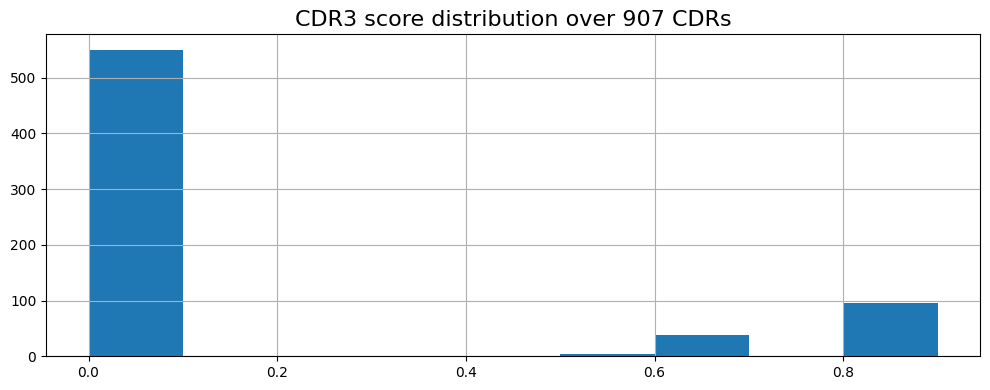

Recall that 0 score implies partial CDR3.


In [54]:
''' 
CDR3 stats
'''
figsize: tuple[int, int] = (10,4)
# --------------------------------
cdr3_file: Path = Path(out_path) / f'TRUST_{Path(fastaq_file).stem}_cdr3.out'
df_cdr3 = pd.read_csv(cdr3_file, sep='\t', names=CDR3_out_cols)
display(df_cdr3)

cdr3_scores = list(df_cdr3['CDR3_score'])

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)

ax.hist(cdr3_scores, np.arange(0, 1, 0.1, dtype=float))
ax.grid()
ax.set_title(f"CDR3 score distribution over {len(cdr3_scores):,} CDRs", fontsize=16)

plt.show()

print("Recall that 0 score implies partial CDR3.")



V: Total of 73 genes: 63 BCR genes and 9 TCR genes.
D: Total of 17 genes: 15 BCR genes and 1 TCR genes.
J: Total of 25 genes: 16 BCR genes and 8 TCR genes.
C: Total of 7 genes: 4 BCR genes and 2 TCR genes.


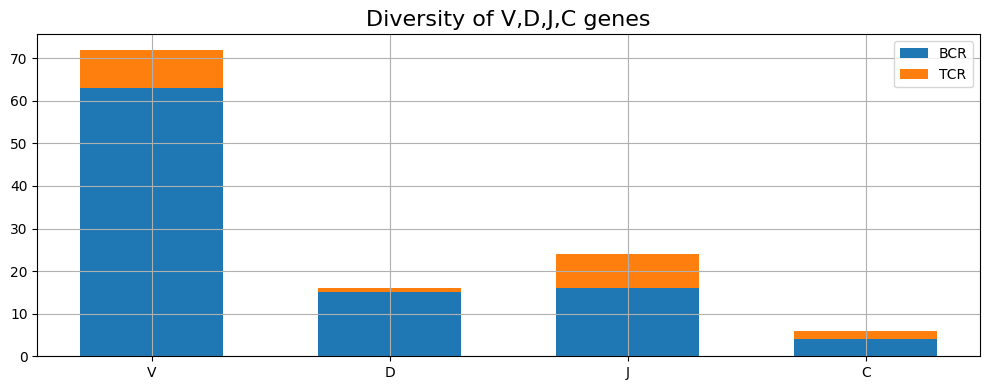

In [ ]:
''' 
VDJC diversity
'''
figsize: tuple[int, int] = (10,4)
width: float = 0.6
# -------------------------------
VDJC_genes_diverisity = defaultdict(list)
for gene in VDJC_genes:
    v_genes = df[gene].unique().tolist()
    v_tcr_genes = [v for v in v_genes if v.startswith('T')]
    v_bcr_genes = [v for v in v_genes if v.startswith('I')]
    print(f"{gene}: Total of {len(v_genes)} genes: {len(v_bcr_genes)} BCR genes and {len(v_tcr_genes)} TCR genes.")
    VDJC_genes_diverisity['BCR'].append(len(v_bcr_genes))
    VDJC_genes_diverisity['TCR'].append(len(v_tcr_genes))

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True, figsize=figsize, squeeze=True)
bottom = np.zeros(len(VDJC_genes))

for gene, gene_bcr_tcr_count in VDJC_genes_diverisity.items():
    ax.bar(VDJC_genes, gene_bcr_tcr_count, width, label=gene, bottom=bottom)
    bottom += gene_bcr_tcr_count
ax.grid()
ax.set_title(f"Diversity of {','.join(VDJC_genes)} genes", fontsize=16)
ax.legend()

plt.show()

In [ ]:
''' 
CDR3 read count
'''



# History

Things we tried:

1. download the SRA toolkit from [here](https://github.com/ncbi/sra-tools/wiki/01.-Downloading-SRA-Toolkit)
1. once download, execute `tar -xzvf sratoolkit.3.2.1-mac-arm64.tar`
1. dataset from Immunophenotyping of COVID-19 and Influenza Underscores the Association of Type I IFN Response in Severe COVID-19 in [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE149689): 

From the downloaded folder execute:
1. ./bin/prefetch SRX8241106 --max-size 30G

Resulted with:
```console
2025-03-31T13:15:00 prefetch.3.2.1: 1) Resolving 'SRX8241106'...
2025-03-31T13:15:03 prefetch.3.2.1: Current preference is set to retrieve SRA Normalized Format files with full base quality scores
2025-03-31T13:15:03 prefetch.3.2.1: 1) Downloading 'SRR11680207'...
2025-03-31T13:15:03 prefetch.3.2.1:  SRA Normalized Format file is being retrieved
2025-03-31T13:15:03 prefetch.3.2.1:  Downloading via HTTPS...
2025-03-31T13:52:10 prefetch.3.2.1:  HTTPS download succeed
2025-03-31T13:52:10 prefetch.3.2.1:   verifying 'SRR11680207'...
2025-03-31T13:52:57 prefetch.3.2.1:  'SRR11680207' is valid: 29607783613 bytes were streamed from 29607781179
2025-03-31T13:52:57 prefetch.3.2.1: 1) 'SRR11680207' was downloaded successfully
2025-03-31T13:52:57 prefetch.3.2.1: 1) Resolving 'SRX8241106's dependencies...
2025-03-31T13:52:57 prefetch.3.2.1: 'SRX8241106' has 0 unresolved dependencies
```

1. then generate the fastaq files: ./bin/fasterq-dump.3.2.1 ./SRR11680207 -t ./temp -O ./SRR11680207

resulted in:
```console
spots read      : 722,551,560
reads read      : 1,445,103,120
reads written   : 1,445,103,120
```



Running on the two fastaq files:
```python
fastq_1_file = 'SRR11680207_1.fastq'
fastq_2_file = 'SRR11680207_2.fastq'

num_threads: int = 8
# -----------------------
ret, stdout, stderr = trust4c.run_paired_fastaq(VDJC_gene_ref_file.name, bcr_tcr_gene_seq_file.name, fastq_1_file, fastq_2_file, extra_params=f" -t {num_threads}")
print(ret, stdout, stderr, sep='\n')
```

Resulted in:
```console
Mon Mar 31 16:43:23 2025] TRUST4 v1.1.5-r573 begins.
[Mon Mar 31 16:43:23 2025] SYSTEM CALL: /usr/local/bin/fastq-extractor -t 8 -f /ref/bcrtcr.fa -o /out/TRUST_SRR11680207_1_toassemble  -1 /data/SRR11680207_1.fastq -2 /data/SRR11680207_2.fastq
[Mon Mar 31 16:43:23 2025] Start to extract candidate reads from read files.
system /usr/local/bin/fastq-extractor -t 8 -f /ref/bcrtcr.fa -o /out/TRUST_SRR11680207_1_toassemble  -1 /data/SRR11680207_1.fastq -2 /data/SRR11680207_2.fastq failed: 9 at /usr/local/bin/run-trust4 line 60
```

Tried also to create the BAM file:
1. ./bin/sam-dump.3.2.1 ./SRR11680207/SRR11680207.sra > ./SRR11680207/SRR11680207.sam
1. samtools view -bS ./SRR11680207/SRR11680207.sam > ./SRR11680207/SRR11680207.bam

And then running on the BAM file resulted in a similar error.

Try now https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE262648:
1. ./bin/prefetch SRR28479475
1. ./bin/sam-dump.3.2.1 ./SRR28479475/SRR28479475.sra > ./SRR28479475/SRR28479475.sam
1. samtools view -bS ./SRR28479475/SRR28479475.sam > ./SRR28479475/SRR28479475.bam